In [1]:
#
# phase2 :
#   Banana model inference
#
%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=cpu,floatX=float32"
import theano
import theano.tensor as T
import config
import numpy as np
import matplotlib.pyplot as plt

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import network
import network.normFlow as nf
import utils
import utils.mathT as mathT
import utils.theanoGeneral as utilsT
import utils.optimizers as optimizers
import utils.plotZ as plotZ
import models.mars as model

In [3]:
DIM = 2
SAMPLINGNUM = 30
floatX = utils.floatX

# constructing graphical model
mb = model.Banana()
x = T.fscalar()
mb.setX( x )
mb.setStd(1.0)

In [4]:
# construction variational model
iaf = nf.NormFlowModel( dim=2, numlayers=16,noisestd=1. )  #(4./DIM)**.5
e = iaf.getNoiseVar(SAMPLINGNUM)
z, logqz = iaf.reparam(e)

# setting cost variable
logpxz,_,_ = mb.logPxz(z)
cost = T.mean( logqz - logpxz ) # KL cost

params = iaf.getParams()
grads = [ T.grad(cost,p,consider_constant=[e]) for p in params ]

In [5]:
# optimisation setup
iaf.reInit()
# opt = optimizers.Adadelta(params)
opt = optimizers.SGD(params,lr=0.05,momentum=0.5,decay=0.001)
updates = opt.getUpdates(params,grads)

outputs = [ cost, T.mean(logpxz), T.mean(logqz) ]
estep = theano.function(inputs=[x],outputs=outputs,updates=updates)

In [8]:
valx = -3

# training
NUMITER = 1000
keys = ['cost','pxz','qz']
record = {}
# mb.setStd(0.7)
for k in keys:
    record[k] = []
for i in range(NUMITER):
    # running updates
    out = estep(valx)
    
    for i,q in enumerate(out):
        record[keys[i]].append( q )        
for k in keys:
    record[k] = np.asarray( record[k] )

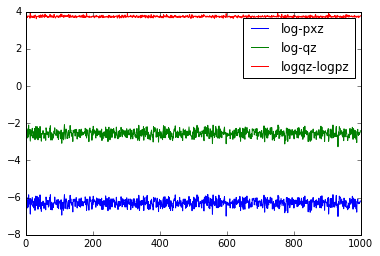

In [9]:
# plt.plot( range(NUMITER), record['cost'],'-' )
# plt.show()
xs = range(NUMITER)
plt.plot( xs, record['pxz'], '-', label='log-pxz')
plt.plot( xs, record['qz'], '-', label='log-qz')
plt.plot( xs, record['cost'], '-', label='logqz-logpz')
plt.legend()
plt.show()

In [12]:
e2 = iaf.getNoiseVar(1000)
z2, logqz2 = iaf.reparam(e2)
fez2 = theano.function(inputs=[],outputs=[e2,z2])

(1000, 2) (1000, 2)


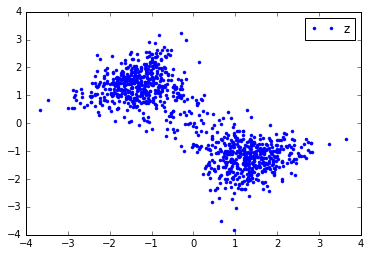

(1000, 2)
x=-3, z1*z2=-1.63097


In [13]:
es, zs = fez2()
print es.shape, zs.shape
# plt.plot(es[:,0],es[:,1],'.',label='e')
plt.plot(zs[:,0],zs[:,1],'.',label='z')
plt.legend(loc=1)
plt.show()
print zs.shape
print 'x=%s, z1*z2=%s' %( valx, np.mean(np.prod(zs,axis=1)) )